# Extrinsics Calibration

In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc("figure", dpi=300)

from dt_computer_vision.camera import CameraModel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography
from dt_computer_vision.ground_projection.rendering import debug_image

In [2]:
from dt_computer_vision.ground_projection import GroundProjector

this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image0.jpg")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]],
    # NOTE: this homography is computed in the 20-entrinsics-calibration jupyter notebook
    "H": [[-2.42749970e-02, 9.46389079e-02, 3.81909422e-01],
          [-4.55028567e-01, -1.17673909e-03, -1.87813039e-02],
          [-1.46006785e-01, 3.29784838e+00, 1]]
}
camera = CameraModel(**camera_properties)
projector = GroundProjector(camera)

assert image.shape == (480, 640, 3)

In [3]:
# rectify image
image = camera.rectifier.rectify(image)

# crop image (bottom-half)
crop_height = int(camera.height * 0.5)
image = image[crop_height:]

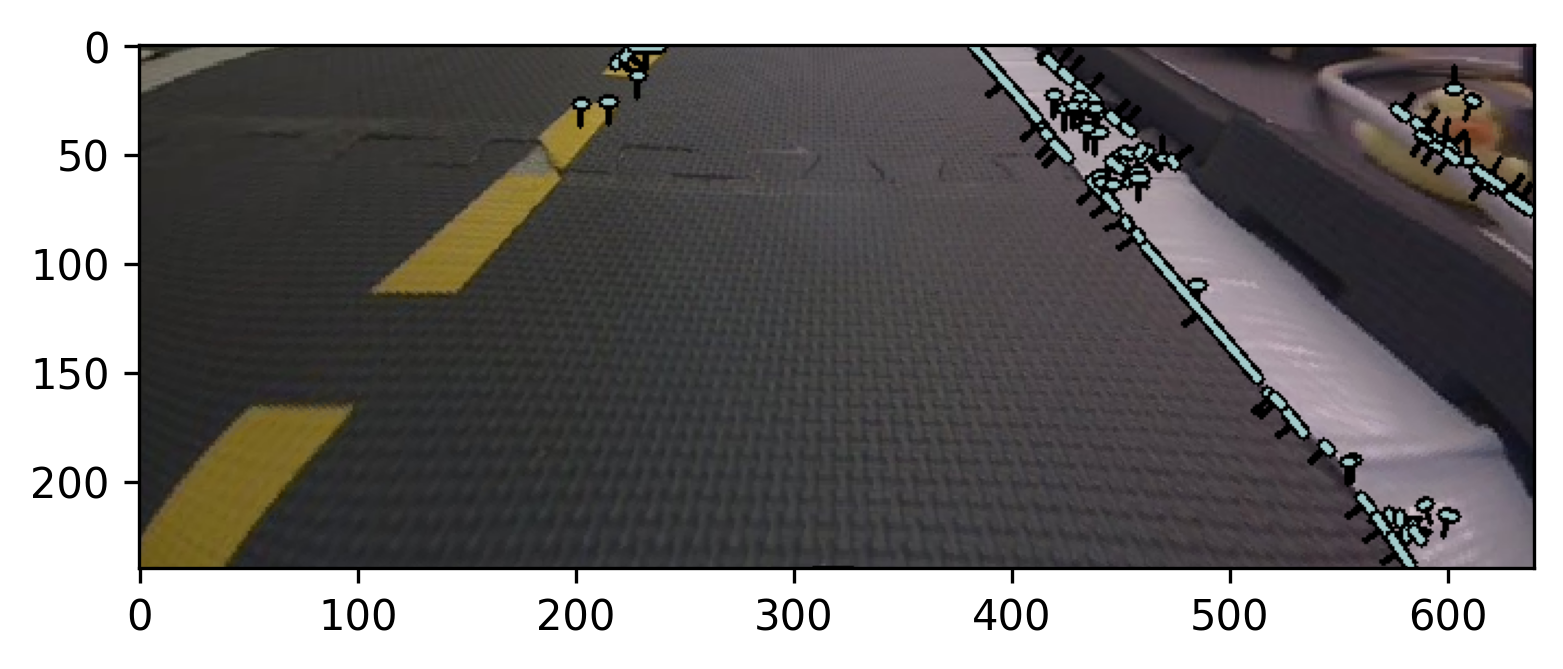

In [4]:
from dt_computer_vision_tests.line_detection_tests.test_detection import detect_color

# detect segments
color: str = "white"
segments, image_w_detections = detect_color(image, color)

# draw segments
image_w_detections = cv2.cvtColor(image_w_detections, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_detections)

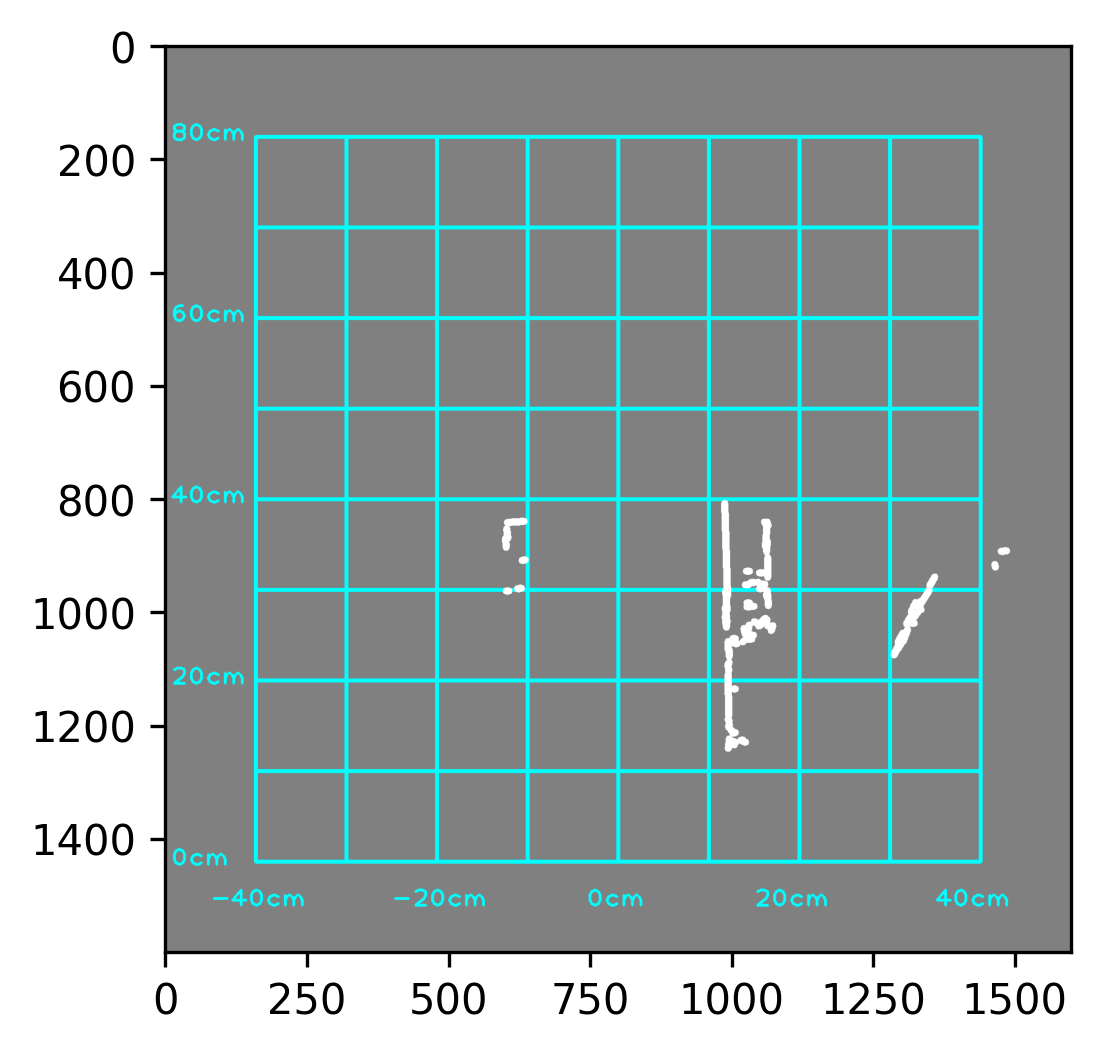

In [5]:
from dt_computer_vision.camera import Pixel

# project segments onto the ground plane
colored_segments = {
    (255, 255, 255): [
        (projector.vector2ground(camera.pixel2vector(Pixel(s[0], s[1] + crop_height))),
         projector.vector2ground(camera.pixel2vector(Pixel(s[2], s[3] + crop_height)))) for s in segments.lines
    ]
}

image_w_projected_segments = debug_image(colored_segments)
image_w_projected_segments = cv2.cvtColor(image_w_projected_segments, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_projected_segments)